In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1048)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [2]:
% matplotlib inline

import os
import os.path as pth

import matplotlib.image as img
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import InceptionResNetV2

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy import stats
from PIL import Image 
from mtcnn import MTCNN


Found 190630 images belonging to 2 classes.
Found 47656 images belonging to 2 classes.
x_data shape :  (20, 600, 600, 3)
t_data shape :  (20,)
[1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]


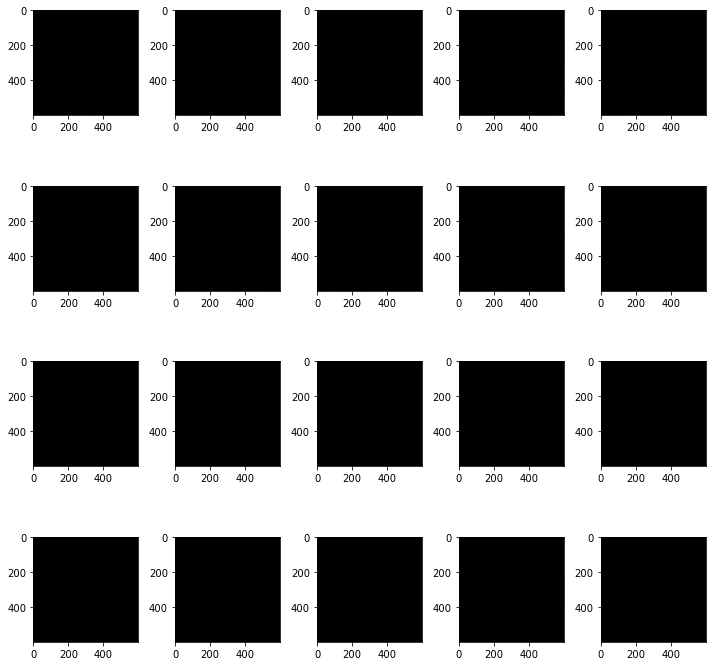

2


In [3]:

real_base_dir = os.listdir('/home/lab22/data/project_deepfake/train_new/real')
fake_base_dir = os.listdir('/home/lab22/data/project_deepfake/train_new/fake')
# validation_dir = './data/deepfake_ex/dataset/validation'

# print(real_base_dir)

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius

    return mask


import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
# import radialProfile
import glob

m = 0
for real_file_path in real_base_dir:    
    epsilon = 1e-8
    filename = pth.join('/home/lab22/data/project_deepfake/train_new/real', real_file_path)
#     print(filename)

    mask = create_circular_mask(600,600,radius=80)
    mask = np.invert(mask)
    inv = np.zeros([600,600,3])
    img_color =[]

    # Read image and split color-channels
    img_color = mpimg.imread(filename)
#     print(img_color)
    img_r = img_color[:,:,0]
    img_b = img_color[:,:,1]
    img_g = img_color[:,:,2]

    # Calculate FFT and appply mask for each channel
    f_r = np.fft.fft2(img_r)
    fshift_r = np.fft.fftshift(f_r)       
    fshift_r = fshift_r*mask       
    f_ishift_r = np.fft.ifftshift(fshift_r)
    img_back_r = np.fft.ifft2(f_ishift_r)
    img_back_r = np.abs(img_back_r)

    f_b = np.fft.fft2(img_b)
    fshift_b = np.fft.fftshift(f_b)
    fshift_b = fshift_b*mask   
    f_ishift_b = np.fft.ifftshift(fshift_b)
    img_back_b = np.fft.ifft2(f_ishift_b)
    img_back_b = np.abs(img_back_b)

    f_g = np.fft.fft2(img_g)
    fshift_g = np.fft.fftshift(f_g)
    fshift_g = fshift_g*mask   
    f_ishift_g = np.fft.ifftshift(fshift_g)
    img_back_g = np.fft.ifft2(f_ishift_g)
    img_back_g = np.abs(img_back_g)

    inv[:,:,0] = np.round(img_back_r)/255
    inv[:,:,1] = np.round(img_back_b)/255
    inv[:,:,2] = np.round(img_back_g)/255

#     # Visualization
#     fig = plt.figure(figsize=(15,15))
#     ax = fig.add_subplot(121)
#     plt.axis('off')
#     ax2 = fig.add_subplot(122)
#     plt.axis('off')

    # Weightning for enhance visualization
    inv2 = np.copy(inv)
    inv2 /= inv.max()
    inv2 *= 6
#     plt.tight_layout()
#     ax.set_title('input image',size=15)
#     ax.imshow(img_color)
#     ax2.set_title('output image (only high-freq comp.)',size=15)
#     ax2.imshow(inv2)
#     plt.show()
    cv2.imwrite('./data/project_deepfake/train_new/real/{}.jpg'.format(m), inv2)
    m += 1

m = 0
for fake_file_path in fake_base_dir:    
    epsilon = 1e-8
    filename = pth.join('/home/lab22/data/project_deepfake/train_new/fake', fake_file_path)
#     print(filename)

    mask = create_circular_mask(600,600,radius=80)
    mask = np.invert(mask)
    inv = np.zeros([600,600,3])
    img_color =[]

    # Read image and split color-channels
    img_color = mpimg.imread(filename)
#     print(img_color)
    img_r = img_color[:,:,0]
    img_b = img_color[:,:,1]
    img_g = img_color[:,:,2]

    # Calculate FFT and appply mask for each channel
    f_r = np.fft.fft2(img_r)
    fshift_r = np.fft.fftshift(f_r)       
    fshift_r = fshift_r*mask       
    f_ishift_r = np.fft.ifftshift(fshift_r)
    img_back_r = np.fft.ifft2(f_ishift_r)
    img_back_r = np.abs(img_back_r)

    f_b = np.fft.fft2(img_b)
    fshift_b = np.fft.fftshift(f_b)
    fshift_b = fshift_b*mask   
    f_ishift_b = np.fft.ifftshift(fshift_b)
    img_back_b = np.fft.ifft2(f_ishift_b)
    img_back_b = np.abs(img_back_b)

    f_g = np.fft.fft2(img_g)
    fshift_g = np.fft.fftshift(f_g)
    fshift_g = fshift_g*mask   
    f_ishift_g = np.fft.ifftshift(fshift_g)
    img_back_g = np.fft.ifft2(f_ishift_g)
    img_back_g = np.abs(img_back_g)

    inv[:,:,0] = np.round(img_back_r)/255
    inv[:,:,1] = np.round(img_back_b)/255
    inv[:,:,2] = np.round(img_back_g)/255

#     # Visualization
#     fig = plt.figure(figsize=(15,15))
#     ax = fig.add_subplot(121)
#     plt.axis('off')
#     ax2 = fig.add_subplot(122)
#     plt.axis('off')

    # Weightning for enhance visualization
    inv2 = np.copy(inv)
    inv2 /= inv.max()
    inv2 *= 6
#     plt.tight_layout()
#     ax.set_title('input image',size=15)
#     ax.imshow(img_color)
#     ax2.set_title('output image (only high-freq comp.)',size=15)
#     ax2.imshow(inv2)
#     plt.show()
    cv2.imwrite('./data/project_deepfake/train_new/fake/{}.jpg'.format(m), inv2)
    m += 1
    
    




Found 190630 images belonging to 2 classes.
Found 47656 images belonging to 2 classes.
x_data shape :  (10, 299, 299, 3)
t_data shape :  (10,)
[1. 1. 1. 1. 0. 0. 1. 1. 0. 0.]


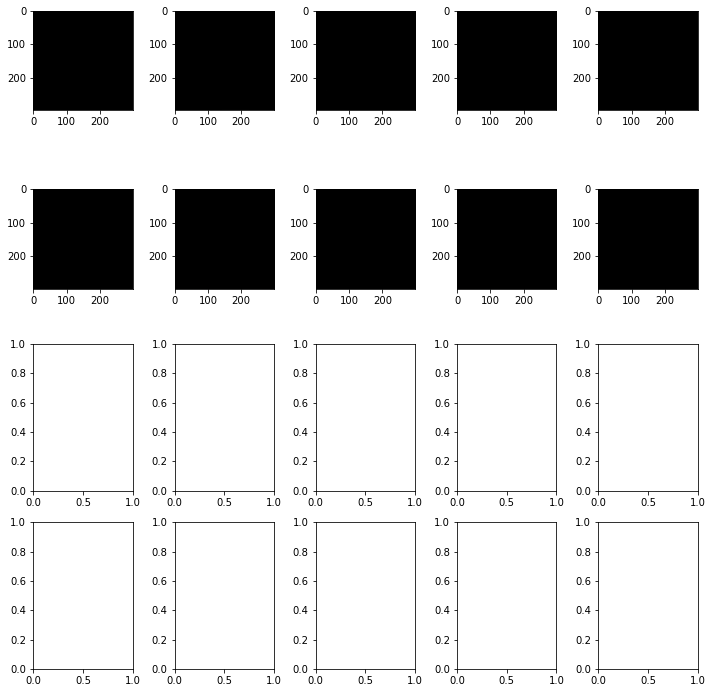

2


In [3]:
train_dir = './data/project_deepfake/train_new'

# ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)
# validation_datagen = ImageDataGenerator(rescale=1/255)

ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    classes=['real','fake'], 
    target_size=(299,299), 
    batch_size=10, 
    class_mode='binary', subset='training') 
validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    classes=['real','fake'], 
    target_size=(299,299), 
    batch_size=10, 
    class_mode='binary', subset='validation') 

# generator에서 출력된 데이터의 shape확인
for x_data, t_data in train_generator:
    print('x_data shape : ', x_data.shape) # (20,299,299,3)
    print('t_data shape : ', t_data.shape) # (20,)
    break;

fig = plt.figure(figsize=(10,10))
axs = []

for i in range(20):
    axs.append(fig.add_subplot(4,5,i+1))
    
for x_data, t_data in train_generator:
    for idx, img_data in enumerate(x_data): # idx => 0~19 , img_data =>(150,150,3)
        axs[idx].imshow(img_data)
    print(t_data)
    break;
    
fig.tight_layout()
plt.show()

nr_of_classes = len(train_generator.class_indices)
print(nr_of_classes)

In [4]:

callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # 검증 정확도 모니터링
                                                   patience=5),             # 1 epoch보다 더 길게 정확도 향상되지 않으면 훈련 중지
                  
                  tf.keras.callbacks.ModelCheckpoint(filepath='./deepfake_sampling_model_1113.h5',
                                                     monitor='val_loss',    # 검증 loss 모니터링
                                                     save_best_only=True),  # 가장 좋은 모델을 저장
                  
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',  # 검증 loss 모니터링
                                                      factor=0.1,           # 콜백 호출시 학습률 10배로 줄임
                                                      patience=5)]          # 검증손실이 해당 epoch만큼 좋아지지 않으면 콜백 호출

In [5]:
# conv_base = InceptionResNetV2(weights='imagenet',
#               include_top=False,
#               input_shape=(224, 224, 3))

# print(conv_base.summary())

# conv_base.trainable = False  # Convolution Layer 동결

# model = Sequential()

# model.add(conv_base)

# model.add(GlobalAveragePooling2D())
# model.add(Dropout(rate=0.5))

# model.add(Dense(units=512, activation='relu'))
# model.add(Dense(units=1, activation='sigmoid'))
# print(model.summary())

with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(299, 299, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.5))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())    
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    print(model.summary())
    


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 35, 35, 128)       0

In [6]:

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [7]:
with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                        steps_per_epoch=2000,  #  batch_size * steps_per_epoch이 train데이타의 양보다 크면 안됨!!!!!
                        epochs=30,
                        validation_data=validation_generator,
                        validation_steps=20)
    
model.save('./deepfake_sampling_model_high_1113.h5')
    

Epoch 1/30
2000/2000 [==============================] - 350s 175ms/step - loss: 0.4296 - accuracy: 0.8198 - val_loss: 0.2450 - val_accuracy: 0.9050
Epoch 2/30
2000/2000 [==============================] - 351s 175ms/step - loss: 0.2410 - accuracy: 0.9180 - val_loss: 0.2667 - val_accuracy: 0.9250
Epoch 3/30
2000/2000 [==============================] - 350s 175ms/step - loss: 0.2255 - accuracy: 0.9253 - val_loss: 0.2729 - val_accuracy: 0.9150
Epoch 4/30
2000/2000 [==============================] - 350s 175ms/step - loss: 0.2187 - accuracy: 0.9280 - val_loss: 0.2519 - val_accuracy: 0.9150
Epoch 5/30
2000/2000 [==============================] - 351s 176ms/step - loss: 0.2100 - accuracy: 0.9312 - val_loss: 0.2630 - val_accuracy: 0.8950
Epoch 6/30
2000/2000 [==============================] - 350s 175ms/step - loss: 0.2095 - accuracy: 0.9323 - val_loss: 0.2159 - val_accuracy: 0.9450
Epoch 7/30
2000/2000 [==============================] - 351s 175ms/step - loss: 0.2059 - accuracy: 0.9313 - val_

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


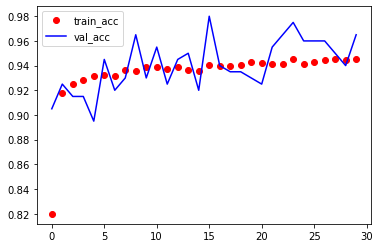

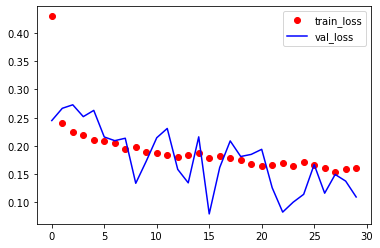

In [8]:
% matplotlib inline
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(history.history.keys())
plt.plot(history.history['accuracy'], 'bo', color='r', label='train_acc')
plt.plot(history.history['val_accuracy'], 'b', color='b', label='val_acc')
plt.legend()
plt.show()
plt.plot(history.history['loss'], 'bo', color='r', label='train_loss')
plt.plot(history.history['val_loss'], 'b', color='b', label='val_loss')
plt.legend()
plt.show()

In [ ]:
# # 기학습 된 모델 불러오기
# model = tf.keras.models.load_model('./deepfake_sampling_model_1111.h5')

In [36]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
# import radialProfile
import glob


path_test = '/home/lab22/data/project_deepfake/test/test_600x600/'
df = pd.read_csv('/home/lab22/data/project_deepfake/sample_submission.csv') 


id_list = df.iloc[:,0].values 
print(len(id_list))

id_list=[path_test + num for num in id_list]

image_w = 299 
image_h = 299 
 
test_img_arr = [] 
prediction=[]
batch_size=20                     
steps=len(id_list)//batch_size
print('-'*70)

def score(s):
    if s >= 0.5:
        return 1
    else:
        return 0

    
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius

    return mask


# print(prediction)
# detector = MTCNN()

for e in range(steps):
    for i, f in enumerate(id_list[e*batch_size:(e+1)*batch_size]): 
        img = Image.open(f) 
#         print(img)
#         img = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
#         print(img)
        img = img.convert("RGB") 
        img = img.resize((image_w, image_h)) 
        print(img)
        
    
    
        epsilon = 1e-8
#         filename = img
        
        mask = create_circular_mask(299,299,radius=80)
        mask = np.invert(mask)
        inv = np.zeros([299,299,3])
        img_color = np.asarray(img)
#         print(img_color)

        # Read image and split color-channels
#         img_color = mpimg.imread(filename)
#         img_color = img_color.resize((image_w, image_h))
#         img_color = filename
        img_r = img_color[:,:,0]
        img_b = img_color[:,:,1]
        img_g = img_color[:,:,2]

        # Calculate FFT and appply mask for each channel
        f_r = np.fft.fft2(img_r)
        fshift_r = np.fft.fftshift(f_r)       
        fshift_r = fshift_r*mask       
        f_ishift_r = np.fft.ifftshift(fshift_r)
        img_back_r = np.fft.ifft2(f_ishift_r)
        img_back_r = np.abs(img_back_r)

        f_b = np.fft.fft2(img_b)
        fshift_b = np.fft.fftshift(f_b)
        fshift_b = fshift_b*mask   
        f_ishift_b = np.fft.ifftshift(fshift_b)
        img_back_b = np.fft.ifft2(f_ishift_b)
        img_back_b = np.abs(img_back_b)

        f_g = np.fft.fft2(img_g)
        fshift_g = np.fft.fftshift(f_g)
        fshift_g = fshift_g*mask   
        f_ishift_g = np.fft.ifftshift(fshift_g)
        img_back_g = np.fft.ifft2(f_ishift_g)
        img_back_g = np.abs(img_back_g)

        inv[:,:,0] = np.round(img_back_r)/255
        inv[:,:,1] = np.round(img_back_b)/255
        inv[:,:,2] = np.round(img_back_g)/255

        # Visualization
#         fig = plt.figure(figsize=(15,10))
#         ax = fig.add_subplot(121)
#         plt.axis('off')
#         ax2 = fig.add_subplot(122)
#         plt.axis('off')

        # Weightning for enhance visualization
        inv2 = np.copy(inv)
        inv2 /= inv.max()
        inv2 *= 6
        img = inv2

#         ax.set_title('input image',size=15)
#         ax.imshow(img_color)
#         ax2.set_title('output image (only high-freq comp.)',size=15)
#         ax2.imshow(inv2)
#         plt.show()
    
    
    
    
        data = np.asarray(img)
        data = data/255                # rescale
        test_img_arr.append(data)  

    test_img_arr = np.array(test_img_arr)               
    result = model.predict(test_img_arr)
    pred = [score(s) for s in result]
    prediction.append(pred)    
    test_img_arr = []
    print(f'Step {e+1}/ {steps}', end='\n')
print('-'*70)

4100
----------------------------------------------------------------------
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB2C5D3650>
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB0C4C3E50>
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB2C5D3B50>
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB2C5D3190>
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB0C4C3E50>
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB2C5D3650>
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB2C2BD990>
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB2C5D3190>
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB2C5D3B50>
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB2C5D3190>
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB0C4C3A90>
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB0C4C3E50>
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB2C5D3B50>
<PIL.Image.Image image mode=RGB size=299x299 at 0x7FAB2C5D3650>
<PIL.Image.Image image mode=

In [37]:
# 제출파일 생성

df = pd.DataFrame({'path': df.iloc[:,0].values, 
                   'y': np.array(prediction).ravel()}, 
                    columns = ['path','y']) 

display(df) 

df.to_csv (r'./team/sample_submisstion_sampling_1113_high.csv', index = False, header=True) 

,path,y
0,leaderboard/image_00000.jpg,0
1,leaderboard/image_00001.jpg,1
2,leaderboard/image_00002.jpg,1
3,leaderboard/image_00003.jpg,0
4,leaderboard/image_00004.jpg,1
...,...,...
4095,leaderboard/image_04095.jpg,0
4096,leaderboard/image_04096.jpg,1
4097,leaderboard/image_04097.jpg,1
4098,leaderboard/image_04098.jpg,0
